In [1]:
import os

import datetime
import pandas as pd
import numpy as np
from scipy.fft import fft
import string

from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import matplotlib.lines as mlines
import seaborn as sns
import skill_metrics as sm
from sklearn.metrics import r2_score

import matplotlib.patches as mpatches

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors  # For RGBA to hex conversion

from src.plots import *
from src.utilities import cal_metrics, mielke_lambda, percentile_mean, fluctuation_frequency

# 2.0 Set variables and functions

In [2]:
# Set inputs
TRANSECTS = ['Transect2', 'Transect5', 'Transect8'] # List of transects for evaluation


fp_input = 'datasets/shorelines' # File path for input data
fp_sub = 'submissions/{}' # File path for submission
fp_resub = 'resubmissions/{}' # File path for resubmission

fn_obs = 'shorelines_obs.csv' # File name for observed shoreline
fn_cali = 'shorelines_calibration.csv' # File name for calibration shoreline
fn_targ_short = 'shorelines_hidden_short.csv' # File name for target shoreline (short-term)
fn_targ_medium = 'shorelines_hidden_medium.csv' # File name for target shoreline (medium-term)
fn_pred_short = 'shorelines_prediction_short.csv' # File name for predicted shoreline (short-term)
fn_pred_medium = 'shorelines_prediction_medium.csv' # File name for predicted shoreline (medium-term)
fn_pred_RCP45 = 'shorelines_prediction_long_RCP45.csv' # File name for predicted shoreline (short-term)
fn_pred_RCP85 = 'shorelines_prediction_long_RCP85.csv' # File name for predicted shoreline (medium-term)

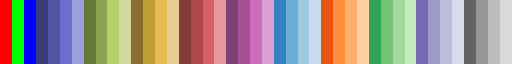

In [3]:
# n_colors = 10

# # Define the colormaps to sample from
# colormap_names = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds']

# # Create an array to store the colors
# colors = []

# # Sample colors from each colormap
# for cmap_name in colormap_names:
#     cmap = plt.get_cmap(cmap_name, n_colors)
#     colors.extend(cmap(np.linspace(0, 1, n_colors))[2:9])

# # Create a new colormap from the combined colors
# cmap = ListedColormap(colors)
# cmap

# Get the colors from tab20b and tab20c
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')

# Combine the colors
colors_tab20b = tab20b(np.linspace(0, 1, 20))
colors_tab20c = tab20c(np.linspace(0, 1, 20))

# Concatenate the two sets of colors
combined_colors = np.vstack((np.array([[1, 0, 0, 1], [0, 1, 0, 1], [0, 0, 1, 1]]), colors_tab20b, colors_tab20c))

# Create a new colormap from the combined colors
cmap = plt.matplotlib.colors.ListedColormap(combined_colors)
cmap

In [4]:
# Read model metadata
df_meta = pd.read_excel('model_summary.xlsx', header=[1])
df_meta = df_meta[~df_meta['Model Name'].str.contains('corrected_JAAA')]
df_meta['Process'] = 'CS_LS'
df_meta.loc[(df_meta['Cross-Shore'].isna())&(~df_meta['Long-Shore'].isna()), 'Process']='LS_Only'
df_meta.loc[(~df_meta['Cross-Shore'].isna())&(df_meta['Long-Shore'].isna()), 'Process']='CS_Only'


# Define groups of interest
model_groups = {
    'DDM': list(df_meta.loc[df_meta['Type']=='DDM', 'Model Name']),
    'HM': list(df_meta.loc[df_meta['Type']=='HM', 'Model Name']),
    'OLM': list(df_meta.loc[df_meta['Type']=='OLM', 'Model Name']),
    'COCOON': list(df_meta.loc[df_meta['Model Name'].str.contains('COCOON'), 'Model Name']),
    'CoSMoS': list(df_meta.loc[df_meta['Model Name'].str.contains('CoSMoS'), 'Model Name']),
    'LSTM': list(df_meta.loc[df_meta['Model Name'].str.contains('LSTM'), 'Model Name']),
    'ShoreFor': list(df_meta.loc[df_meta['Model Name'].str.contains('ShoreFor'), 'Model Name']),
    'CS_Only': list(df_meta.loc[df_meta['Process']=='CS_Only', 'Model Name']),
    'LS_Only': list(df_meta.loc[df_meta['Process']=='LS_Only', 'Model Name']),
    'CS_LS': list(df_meta.loc[df_meta['Process']=='CS_LS', 'Model Name']),
}

# 2.1 Prediction evaluation (Short-term)

## 2.1.1 Load predictions, calculate ensemble and loss

In [5]:
# Load prediction
MODELS = list(df_meta['Model Name'].values)
MODEL_TYPES = dict(zip(MODELS, df_meta['Type']))
MODEL_COLORS = dict(zip(df_meta['Model Name'], cmap.colors[0:len(df_meta)]))

# Read obs and calibration shoreline data
df_obs = pd.read_csv(os.path.join(fp_input, fn_obs), index_col='Datetime')
df_obs.index = pd.to_datetime(df_obs.index)
df_obs.sort_index(inplace=True)

# Read obs and calibration shoreline data
df_targ = pd.read_csv(os.path.join(fp_input, fn_targ_short), index_col='Datetime')
df_targ.index = pd.to_datetime(df_targ.index)
df_targ.sort_index(inplace=True)

# Read model calibrations
dfs_pred = {}
freqs_pred = {} # This saves the frequency level of preds. High freq preds will be plotted on the bottom.
for model in MODELS:
    if df_meta.loc[df_meta['Model Name']==model, 'Submission Type'].values[0] == 'Submission':
        fp = fp_sub
    else:
        fp = fp_resub
    
    try:
        df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_short), index_col='Datetime')
    except:
        df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_short), index_col='datetime')
        df_pred.index.name = 'Datetime'
    df_pred.index = pd.to_datetime(df_pred.index)
    df_pred.sort_index(inplace=True)
    dfs_pred[model] = df_pred
    freqs_pred[model] = df_pred.apply(fluctuation_frequency).median()

In [6]:
# Calculate ensembles
ensemble_values = []
index = pd.date_range(start='2019-01-01', end='2023-12-31')

for key, df_pred in dfs_pred.items():
    ensemble_values.append(df_pred[TRANSECTS].reindex(index).values) 
ensemble_values = np.stack(ensemble_values)
#ensemble_mean = np.mean(ensemble_values, axis=0)
ensemble_mean = percentile_mean(ensemble_values, 5, 95, axis=0)
ensemble_median = np.nanmedian(ensemble_values, axis=0)
ensemble_max = np.nanmax(ensemble_values, axis=0)
ensemble_min = np.nanmin(ensemble_values, axis=0)
ensemble_std = np.nanstd(ensemble_values, axis=0)

dfs_pred['Ensemble'] = pd.DataFrame(ensemble_mean, columns=TRANSECTS, index=index)
if 'Ensemble' not in MODELS:
    MODELS.append('Ensemble')
MODEL_TYPES['Ensemble'] = 'ENS'
MODEL_COLORS['Ensemble'] = 'k'

In [7]:
# Calculate metrics
df_loss = pd.DataFrame(columns=TRANSECTS, index=dfs_pred.keys()) # Dataframe to save loss for model and transects
metrics_all = {}

for i, tran_id in enumerate(TRANSECTS):
    metrics = {}
    
    # Calculate metrics for the target
    metrics["Target"] = cal_metrics(df_targ[[tran_id]], df_targ[[tran_id]])
    metrics["Prediction"] = {}
    for model in dfs_pred.keys():
        # Calculate metrics for predictions
        metrics["Prediction"][model] = cal_metrics(df_targ[[tran_id]], dfs_pred[model][[tran_id]])
        df_loss.loc[model, tran_id] = metrics["Prediction"][model]['loss']
    metrics_all[tran_id] = metrics
    
# Sort zorder based on freq
sorted_freq = {k: v for k, v in sorted(freqs_pred.items(), key=lambda item: item[1], reverse=True)}
zorders = {model: i for i, model in enumerate(sorted_freq.keys(), 1)}
zorders['Ensemble'] = 41
zorders['CoSMoS-COAST-CONV_SV'] = 40
zorders['GAT-LSTM_YM'] = 39
zorders['iTransformer-KC'] = 38

## 2.1.2 Timeseries comparison

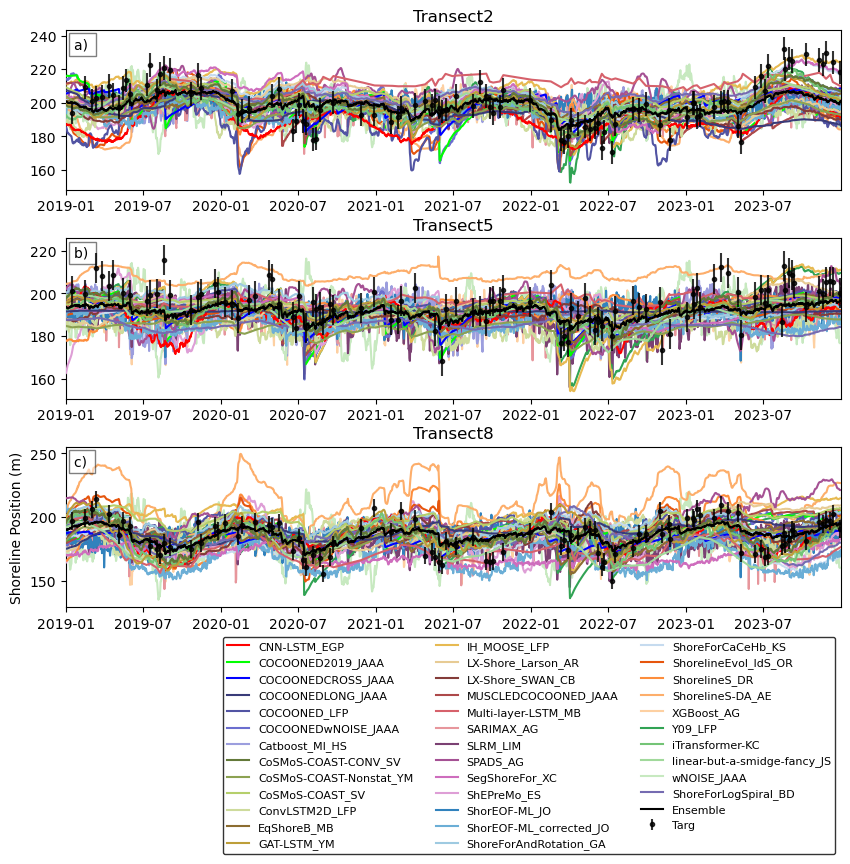

In [8]:

# Plot timeseries comparison
fig = plot_ts(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred, task='short', zorders=zorders, colors=MODEL_COLORS)
plt.savefig('figures/Short/Timeseries_all.jpg', dpi=300, bbox_inches='tight')

fig = plot_ts_interactive(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred, task='short', zorders=zorders, 
                         colors=MODEL_COLORS, loss=df_loss.mean(1))
fig.write_html('figures/Short/Timeseries.html')

# Save timeseries for group comparison
for group_name, group_elements in model_groups.items():
    dfs_pred_group = {key: dfs_pred[key] for key in group_elements if key in dfs_pred}
    fig = plot_ts(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred_group, task='short', zorders=zorders, 
                  colors=MODEL_COLORS, loss=df_loss.mean(1))
    plt.savefig('figures/Short/Timeseries_{}.jpg'.format(group_name), dpi=300, bbox_inches='tight')
    plt.close(fig)

## 2.1.3 Taylor Diagram for model ranking

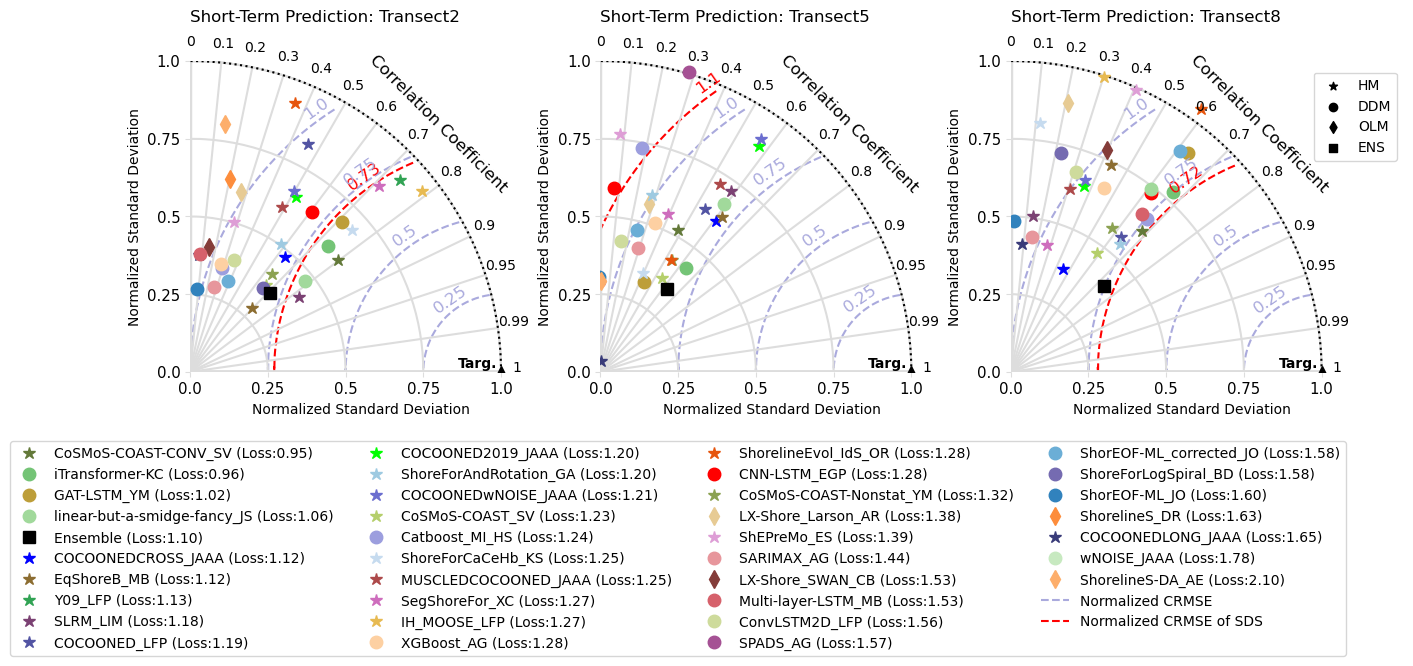

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))


for i, tran_id in enumerate(TRANSECTS):
    metrics = metrics_all[tran_id]
    ax = axes[i]
    if i != len(TRANSECTS)-1:
        ax = plot_taylor(metrics, MODEL_TYPES, MODEL_COLORS, legend=None, ax=ax, 
                         SDS_RMS=round(10/df_targ.std()[tran_id], 2))
    else:
        ax = plot_taylor(metrics, MODEL_TYPES, MODEL_COLORS, legend='Average', 
                         aver_scores=df_loss.mean(1), ax=ax, 
                         SDS_RMS=round(10/df_targ.std()[tran_id], 2))
        
    ax.set_title('Short-Term Prediction: {}'.format(tran_id), loc="left", y=1.1)

plt.subplots_adjust(wspace=0.2)
plt.savefig('figures/Short/TaylorDiagram.jpg', dpi=300, bbox_inches='tight')
df_loss['Avg'] = df_loss.mean(1)


## 2.1.3 Visualize ensemble

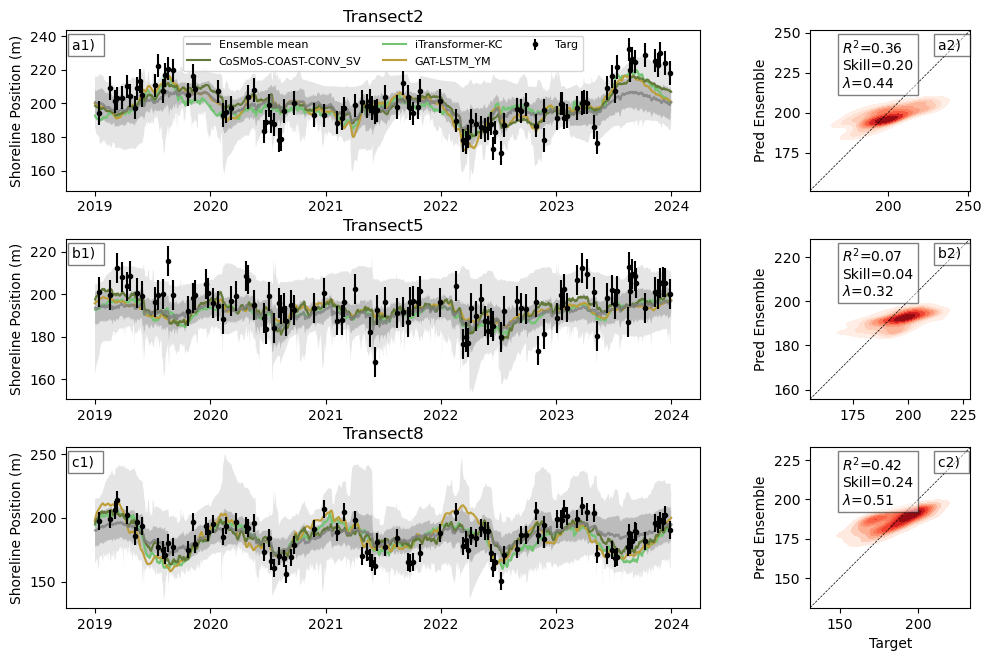

In [10]:
top_models = list(df_loss.sort_values('Avg').drop('Ensemble').index[:3])
fig = vis_ensemble(index, ensemble_mean, ensemble_min, ensemble_max, ensemble_std, df_targ, dfs_pred, top_models, 
                   TRANSECTS, MODEL_COLORS, zorders)
plt.savefig('figures/Short/Ensemble.jpg', dpi=300, bbox_inches='tight')

## 2.1.4 visualize loss variations

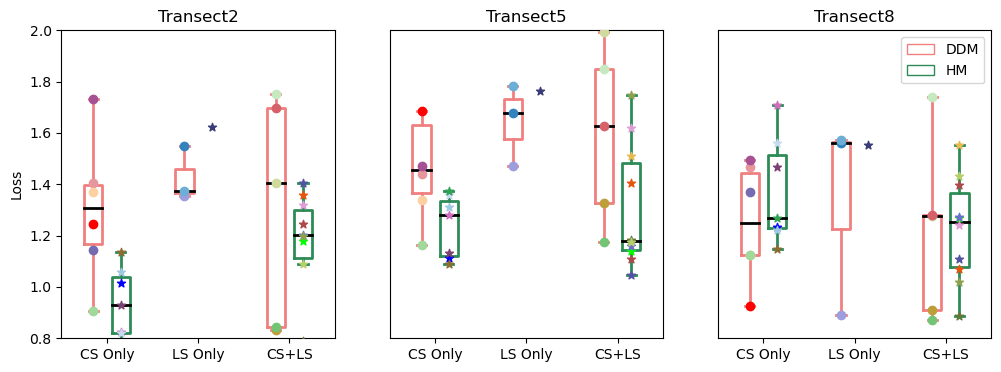

In [11]:
fig = loss_boxplot(df_loss, df_meta, TRANSECTS, MODEL_COLORS)
for ax in fig.get_axes():
    ax.set_ylim(0.8, 2)
plt.savefig('figures/Short/Boxplot.jpg', dpi=300, bbox_inches='tight')

# 2.2 Prediction evaluation (Medium-term, pre 1986)

## 2.2.1 Load predictions, calculate ensemble and loss

In [12]:
sep_time = datetime.datetime(year=1986, month=1, day=1) # Separate medium prediction to two periods

In [13]:
# Load predictions

MODELS = list(df_meta['Model Name'].values)
MODEL_TYPES = dict(zip(MODELS, df_meta['Type']))
MODEL_COLORS = dict(zip(df_meta['Model Name'], cmap.colors[0:len(df_meta)]))

# Read obs and calibration shoreline data
df_targ = pd.read_csv(os.path.join(fp_input, fn_targ_medium), index_col='Datetime')
df_targ.index = pd.to_datetime(df_targ.index)
df_targ.sort_index(inplace=True)
df_targ = df_targ.loc[df_targ.index<sep_time]

# Read model calibrations
dfs_pred = {}
for model in MODELS:
    if df_meta.loc[df_meta['Model Name']==model, 'Submission Type'].values[0] == 'Submission':
        fp = fp_sub
    else:
        fp = fp_resub
    if os.path.exists(os.path.join(fp.format(model), fn_pred_medium)):

        try:
            df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_medium), index_col='Datetime')
        except:
            df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_medium), index_col='datetime')
            df_pred.index.name = 'Datetime'
        df_pred.index = pd.to_datetime(df_pred.index)
        df_pred.sort_index(inplace=True)
        dfs_pred[model] = df_pred.loc[df_pred.index<sep_time]

In [14]:
# Calculate ensemble

ensemble_values = []
index = pd.date_range(start='1951-05-01', end='1985-12-31')
for key, df_pred in dfs_pred.items():
    ensemble_values.append(df_pred[TRANSECTS].reindex(index).values)  
ensemble_values = np.stack(ensemble_values)
#ensemble_mean = np.mean(ensemble_values, axis=0)
ensemble_mean = percentile_mean(ensemble_values, 10, 90, axis=0)
ensemble_median = np.nanmedian(ensemble_values, axis=0)
ensemble_max = np.nanmax(ensemble_values, axis=0)
ensemble_min = np.nanmin(ensemble_values, axis=0)
ensemble_std = np.nanstd(ensemble_values, axis=0)

dfs_pred['Ensemble'] = pd.DataFrame(ensemble_mean, columns=TRANSECTS, index=index)
MODELS = list(df_meta['Model Name'].values)
MODEL_TYPES = dict(zip(MODELS, df_meta['Type']))
MODEL_COLORS = dict(zip(df_meta['Model Name'], cmap.colors[0:len(df_meta)]))
if 'Ensemble' not in MODELS:
    MODELS.append('Ensemble')
MODEL_TYPES['Ensemble'] = 'ENS'
MODEL_COLORS['Ensemble'] = 'k'

In [15]:
# Calculate metrics
df_loss = pd.DataFrame(columns=TRANSECTS, index=dfs_pred.keys()) # Dataframe to save loss for model and transects
metrics_all = {}

for i, tran_id in enumerate(TRANSECTS):
    metrics = {}
    
    # Calculate metrics for the target
    metrics["Target"] = cal_metrics(df_targ[[tran_id]], df_targ[[tran_id]])
    metrics["Prediction"] = {}
    for model in dfs_pred.keys():
        # Calculate metrics for predictions
        metrics["Prediction"][model] = cal_metrics(df_targ[[tran_id]], dfs_pred[model][[tran_id]])
        df_loss.loc[model, tran_id] = metrics["Prediction"][model]['loss']
    metrics_all[tran_id] = metrics

## 2.2.2 Timeseries comparison (pre 1986)

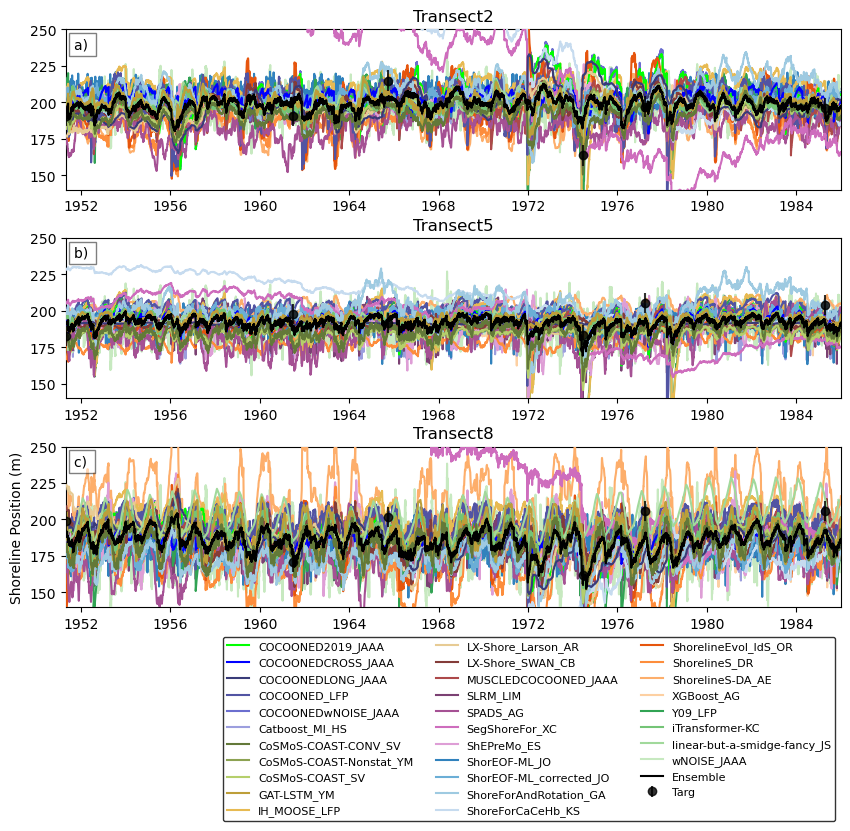

In [16]:
# Plot timeseries comparison
fig = plot_ts(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred, task='medium', zorders=zorders, colors=MODEL_COLORS)
for ax in fig.get_axes():
    ax.set_ylim(140, 250)
plt.savefig('figures/Medium_pre1986/Timeseries_all.jpg', dpi=300, bbox_inches='tight')

fig = plot_ts_interactive(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred, task='medium', zorders=zorders, 
                         colors=MODEL_COLORS, loss=df_loss.mean(1))
fig.write_html('figures/Medium_pre1986/Timeseries.html')

# Save timeseries for group comparison
for group_name, group_elements in model_groups.items():
    dfs_pred_group = {key: dfs_pred[key] for key in group_elements if key in dfs_pred}
    fig = plot_ts(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred_group, task='medium', zorders=zorders, 
                  colors=MODEL_COLORS, loss=df_loss.mean(1))
    plt.savefig('figures/Medium_pre1986/Timeseries_{}.jpg'.format(group_name), dpi=300, bbox_inches='tight')
    plt.close(fig)

## 2.2.3 Taylor Diagram for model ranking (pre 1986)

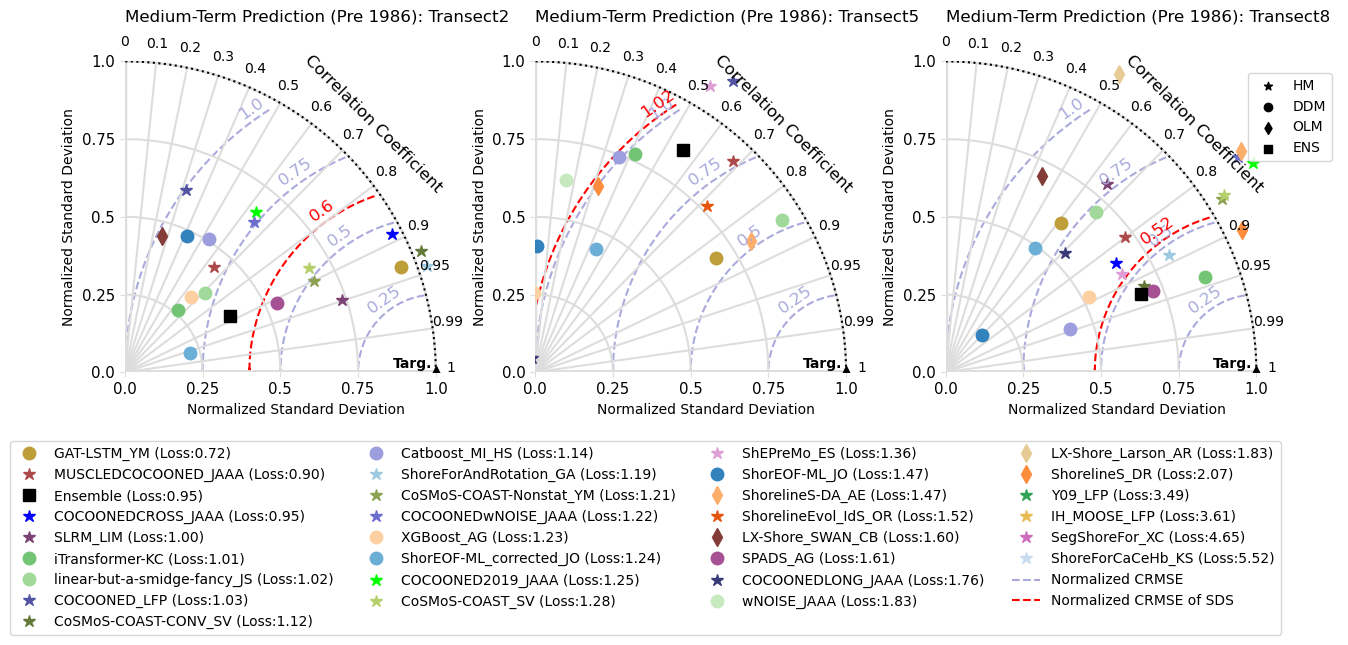

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))


for i, tran_id in enumerate(TRANSECTS):
    metrics = metrics_all[tran_id]
    
    # Calculate metrics for the target
    metrics["Target"] = cal_metrics(df_targ[[tran_id]], df_targ[[tran_id]])
    metrics["Prediction"] = {}
    for model in dfs_pred.keys():
        # Calculate metrics for predictions
        metrics["Prediction"][model] = cal_metrics(df_targ[[tran_id]], dfs_pred[model][[tran_id]])
        df_loss.loc[model, tran_id] = metrics["Prediction"][model]['loss']


    ax = axes[i]
    if i != len(TRANSECTS)-1:
        ax = plot_taylor(metrics, MODEL_TYPES, MODEL_COLORS, legend=None, ax=ax, 
                         SDS_RMS=round(10/df_targ.std()[tran_id], 2))
    else:
        ax = plot_taylor(metrics, MODEL_TYPES, MODEL_COLORS, legend='Average', 
                         aver_scores=df_loss.mean(1), ax=ax, 
                         SDS_RMS=round(10/df_targ.std()[tran_id], 2))
    ax.set_title('Medium-Term Prediction (Pre 1986): {}'.format(tran_id), loc="left", y=1.1)
df_loss['Avg'] = df_loss.mean(1)
plt.subplots_adjust(wspace=0.2)
plt.savefig('figures/Medium_pre1986/TaylorDiagram.jpg', dpi=300, bbox_inches='tight')

## 2.2.4 Visualize ensemble

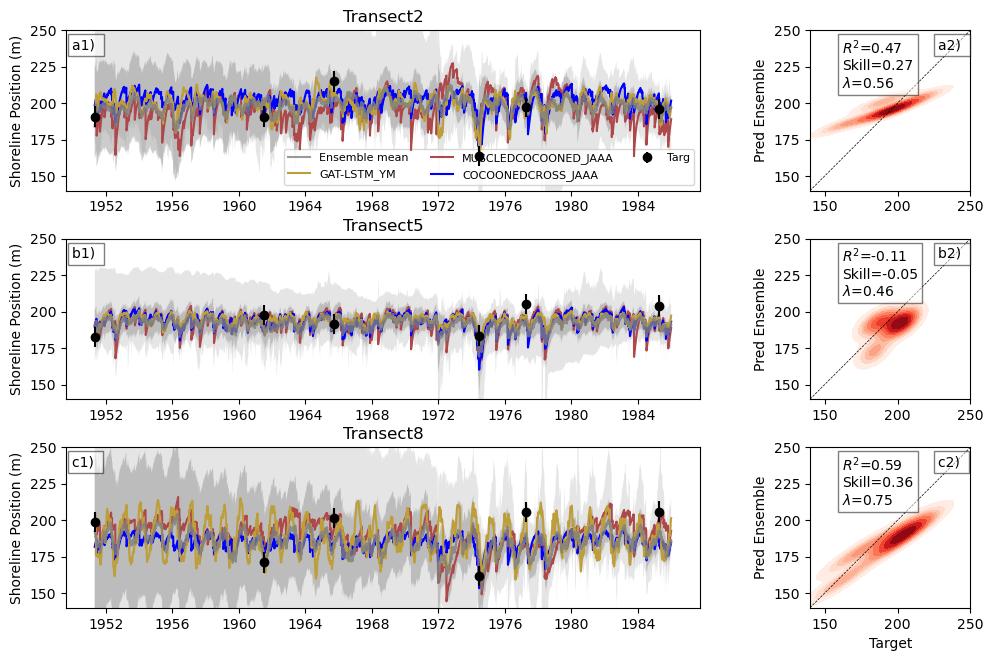

In [18]:
top_models = list(df_loss.sort_values('Avg').drop('Ensemble').index[:3])
fig = vis_ensemble(index, ensemble_mean, ensemble_min, ensemble_max, ensemble_std, df_targ, dfs_pred, top_models, 
                   TRANSECTS, MODEL_COLORS, zorders)
for i, ax in enumerate(fig.get_axes()):
    ax.set_ylim(140, 250)
    if i%2==1:
        ax.set_xlim(140, 250)
plt.savefig('figures/Medium_pre1986/Ensemble.jpg', dpi=300, bbox_inches='tight')

## 2.2.5 loss variations

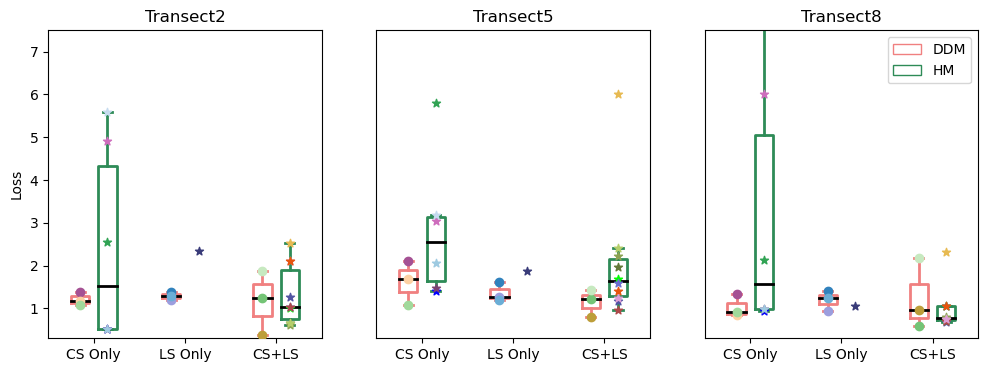

In [19]:
df_meta_medium = df_meta.copy()
df_meta_medium.loc[df_meta_medium['Model Name']=='LX-Shore_Larson_AR', 'Cross-Shore'] = np.nan
fig = loss_boxplot(df_loss, df_meta, TRANSECTS, MODEL_COLORS)
for ax in fig.get_axes():
    ax.set_ylim(0.3, 7.5)
plt.savefig('figures/Medium_pre1986/Boxplot.jpg', dpi=300, bbox_inches='tight')

# 2.3 Prediction evaluation (Medium-term, post 1986)

## 2.3.1 Load predictions and calculate ensemble

In [24]:
MODELS = list(df_meta['Model Name'].values)
MODEL_TYPES = dict(zip(MODELS, df_meta['Type']))
MODEL_COLORS = dict(zip(df_meta['Model Name'], cmap.colors[0:len(df_meta)]))


# Read obs and calibration shoreline data
df_targ = pd.read_csv(os.path.join(fp_input, fn_targ_medium), index_col='Datetime')
df_targ.index = pd.to_datetime(df_targ.index)
df_targ.sort_index(inplace=True)
df_targ = df_targ.loc[df_targ.index>=sep_time]

# Read model calibrations
dfs_pred = {}
for model in MODELS:
    if df_meta.loc[df_meta['Model Name']==model, 'Submission Type'].values[0] == 'Submission':
        fp = fp_sub
    else:
        fp = fp_resub
    if os.path.exists(os.path.join(fp.format(model), fn_pred_medium)):
        try:
            df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_medium), index_col='Datetime')
        except:
            df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_medium), index_col='datetime')
            df_pred.index.name = 'Datetime'
        df_pred.index = pd.to_datetime(df_pred.index)
        df_pred.sort_index(inplace=True)
        dfs_pred[model] = df_pred.loc[df_pred.index>=sep_time]

In [25]:
# Calculate ensemble
ensemble_values = []
index = pd.date_range(start='1986-01-01', end='1999-02-16')
for key, df_pred in dfs_pred.items():
    ensemble_values.append(df_pred[TRANSECTS].reindex(index).values)  
ensemble_values = np.stack(ensemble_values)
#ensemble_mean = np.mean(ensemble_values, axis=0)
ensemble_mean = percentile_mean(ensemble_values, 10, 90, axis=0)
ensemble_median = np.median(ensemble_values, axis=0)
ensemble_max = np.nanmax(ensemble_values, axis=0)
ensemble_min = np.nanmin(ensemble_values, axis=0)
ensemble_std = np.nanstd(ensemble_values, axis=0)

dfs_pred['Ensemble'] = pd.DataFrame(ensemble_mean, columns=TRANSECTS, index=index)
MODELS = list(df_meta['Model Name'].values)
MODEL_TYPES = dict(zip(MODELS, df_meta['Type']))
MODEL_COLORS = dict(zip(df_meta['Model Name'], cmap.colors[0:len(df_meta)]))
MODELS.append('Ensemble')
MODEL_TYPES['Ensemble'] = 'ENS'
MODEL_COLORS['Ensemble'] = 'k'

In [26]:
# Calculate metrics
df_loss = pd.DataFrame(columns=TRANSECTS, index=dfs_pred.keys()) # Dataframe to save loss for model and transects
metrics_all = {}

for i, tran_id in enumerate(TRANSECTS):
    metrics = {}
    
    # Calculate metrics for the target
    metrics["Target"] = cal_metrics(df_targ[[tran_id]], df_targ[[tran_id]])
    metrics["Prediction"] = {}
    for model in dfs_pred.keys():
        # Calculate metrics for predictions
        metrics["Prediction"][model] = cal_metrics(df_targ[[tran_id]], dfs_pred[model][[tran_id]])
        df_loss.loc[model, tran_id] = metrics["Prediction"][model]['loss']
    metrics_all[tran_id] = metrics

## 2.3.2 Timeseries comparison (post 1986)

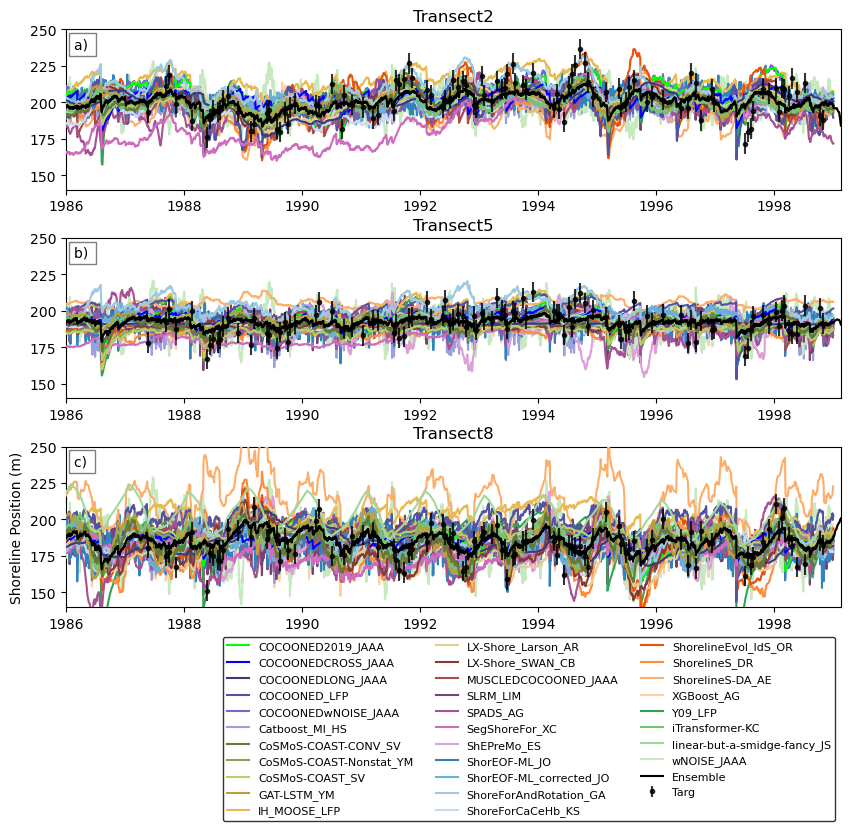

In [27]:
# Plot timeseries comparison
fig = plot_ts(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred, task='medium', zorders=zorders, colors=MODEL_COLORS)
for ax in fig.get_axes():
    ax.set_ylim(140, 250)
plt.savefig('figures/Medium_post1986/Timeseries_all.jpg', dpi=300, bbox_inches='tight')


fig = plot_ts_interactive(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred, task='medium', zorders=zorders, 
                         colors=MODEL_COLORS, loss=df_loss.mean(1))
fig.write_html('figures/Medium_post1986/Timeseries.html')

# Save timeseries for group comparison
for group_name, group_elements in model_groups.items():
    dfs_pred_group = {key: dfs_pred[key] for key in group_elements if key in dfs_pred}
    fig = plot_ts(TRANSECTS, df_targ=df_targ, dfs_pred=dfs_pred_group, task='medium', zorders=zorders, 
                  colors=MODEL_COLORS, loss=df_loss.mean(1))
    plt.savefig('figures/Medium_post1986/Timeseries_{}.jpg'.format(group_name), dpi=300, bbox_inches='tight')
    plt.close(fig)

## 2.3.3 Taylor Diagram for model ranking (post 1986)

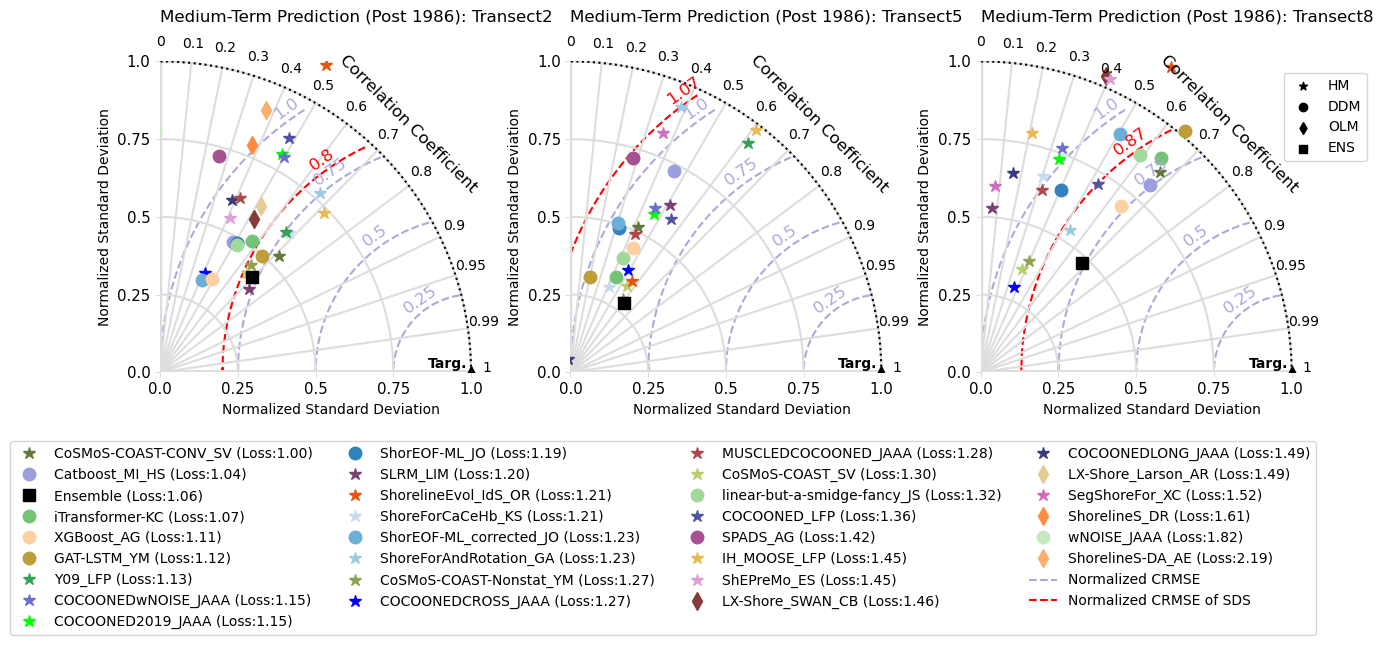

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

for i, tran_id in enumerate(TRANSECTS):
    metrics = metrics_all[tran_id]

    ax = axes[i]
    if i != len(TRANSECTS)-1:
        ax = plot_taylor(metrics, MODEL_TYPES, MODEL_COLORS, legend=None, ax=ax, 
                         SDS_RMS=round(10/df_targ.std()[tran_id], 2))
    else:
        ax = plot_taylor(metrics, MODEL_TYPES, MODEL_COLORS, legend='Average', 
                         aver_scores=df_loss.mean(1), ax=ax, 
                         SDS_RMS=round(10/df_targ.std()[tran_id], 2))
    ax.set_title('Medium-Term Prediction (Post 1986): {}'.format(tran_id), loc="left", y=1.1)
df_loss['Avg'] = df_loss.mean(1)
plt.subplots_adjust(wspace=0.2)
plt.savefig('figures/Medium_post1986/TaylorDiagram.jpg', dpi=300, bbox_inches='tight')

## 2.3.4 Plot ensemble (post 1986)

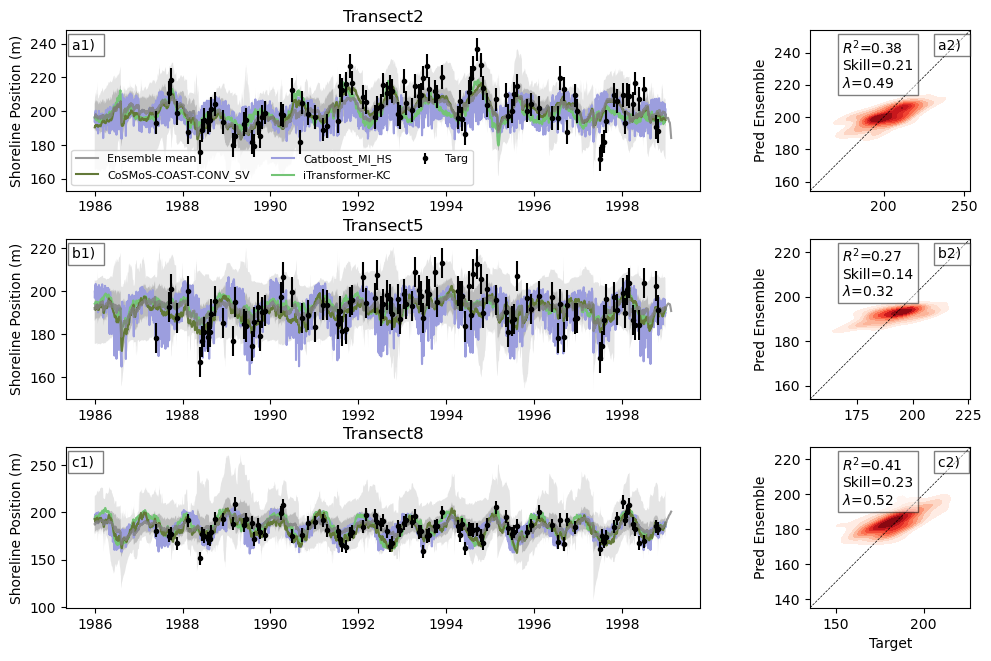

In [29]:
top_models = list(df_loss.sort_values('Avg').drop('Ensemble').index[:3])
fig = vis_ensemble(index, ensemble_mean, ensemble_min, ensemble_max, ensemble_std, df_targ, dfs_pred, top_models, 
                   TRANSECTS, MODEL_COLORS, zorders)
plt.savefig('figures/Medium_post1986/Ensemble.jpg', dpi=300, bbox_inches='tight')

## 2.2.5 loss variations

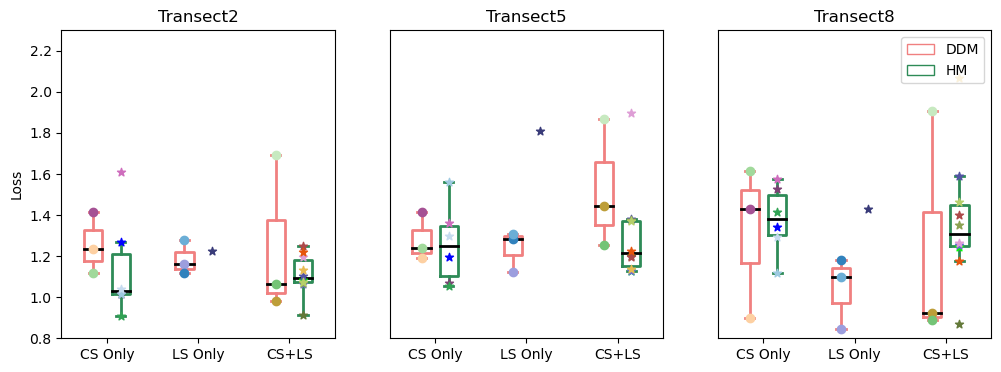

In [30]:
df_meta_medium = df_meta.copy()
df_meta_medium.loc[df_meta_medium['Model Name']=='LX-Shore_Larson_AR', 'Cross-Shore'] = np.nan # Based on notes from Dano
fig = loss_boxplot(df_loss, df_meta, TRANSECTS, MODEL_COLORS)
for ax in fig.get_axes():
    ax.set_ylim(0.8, 2.3)
plt.savefig('figures/Medium_post1986/Boxplot.jpg', dpi=300, bbox_inches='tight')

# 2.3 Long-term

## 2.3.1 Load predictions

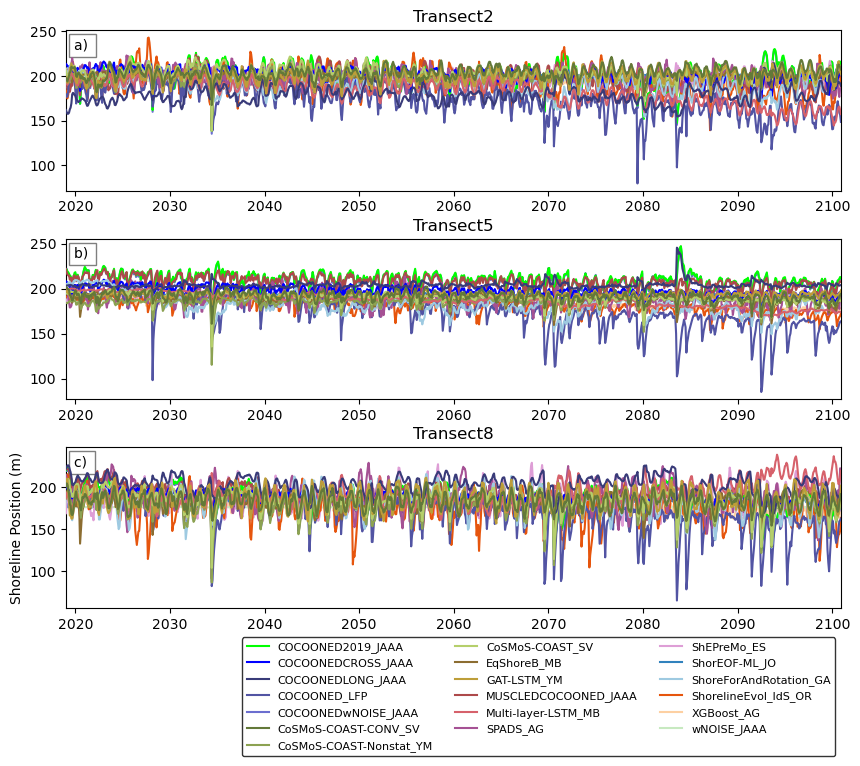

In [31]:
# RCP 4.5

MODELS = list(df_meta['Model Name'].values)
MODEL_TYPES = dict(zip(MODELS, df_meta['Type']))
MODEL_COLORS = dict(zip(df_meta['Model Name'], cmap.colors[0:len(df_meta)]))
MODELS.remove('ShoreForCaCeHb_KS')

# Read model calibrations
dfs_pred_RCP45 = {}
for model in MODELS:
    if os.path.exists(os.path.join(fp_sub.format(model), fn_pred_RCP45)):
        if df_meta.loc[df_meta['Model Name']==model, 'Submission Type'].values[0] == 'Submission':
            fp = fp_sub
        else:
            fp = fp_resub
        try:
            df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_RCP45), index_col='Datetime')
        except:
            df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_RCP45), index_col='datetime')
            df_pred.index.name = 'Datetime'
        if df_pred.iloc[0].mean()<100: # Some COCOONED model provides relative shoreline position
            df_pred_short = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred_short), index_col='Datetime')
            df_pred = df_pred + df_pred_short.iloc[0]
        df_pred.index = pd.to_datetime(df_pred.index)
        df_pred.sort_index(inplace=True)
        dfs_pred_RCP45[model] = df_pred.resample('1MS').mean()

fig = plot_ts(TRANSECTS, dfs_pred=dfs_pred_RCP45, task='long', zorders=zorders, colors=MODEL_COLORS)
plt.savefig('figures/Long/Timeseries_RCP45.jpg', dpi=300, bbox_inches='tight')
fig = plot_ts_interactive(TRANSECTS, dfs_pred=dfs_pred_RCP45, task='long', zorders=zorders, 
                         colors=MODEL_COLORS)
fig.write_html('figures/Long/Timeseries_RCP45.html') 

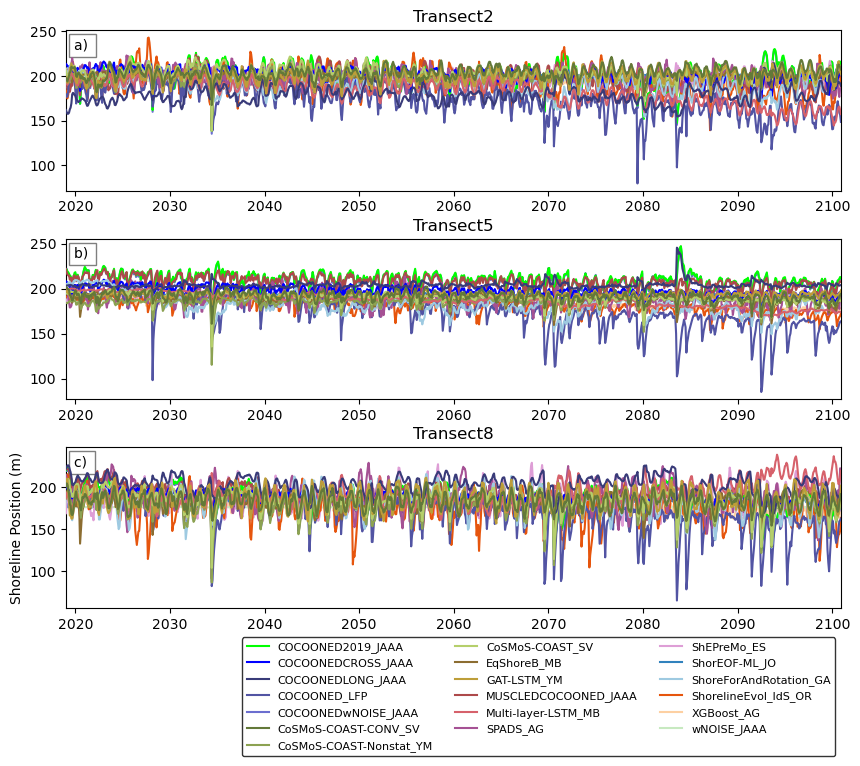

In [32]:
#RCP8.5

MODELS = list(df_meta['Model Name'].values)
MODEL_TYPES = dict(zip(MODELS, df_meta['Type']))
MODEL_COLORS = dict(zip(df_meta['Model Name'], cmap.colors[0:len(df_meta)]))
MODELS.remove('ShoreForCaCeHb_KS')

# Read model calibrations
dfs_pred_RCP85 = {}
for model in MODELS:
    if os.path.exists(os.path.join(fp_sub.format(model), fn_pred_RCP85)):
        try:
            df_pred = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred_RCP85), index_col='Datetime')
        except:
            df_pred = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred_RCP85), index_col='datetime')
            df_pred.index.name = 'Datetime'
        if df_pred.iloc[0].mean()<100: # Some COCOONED model provides relative shoreline position
            df_pred_short = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred_short), index_col='Datetime')
            df_pred = df_pred + df_pred_short.iloc[0]
        
        df_pred.index = pd.to_datetime(df_pred.index)
        df_pred.sort_index(inplace=True)
        dfs_pred_RCP85[model] = df_pred.resample('1MS').mean()
    
fig = plot_ts(TRANSECTS, dfs_pred=dfs_pred_RCP45, task='long', zorders=zorders, colors=MODEL_COLORS)
plt.savefig('figures/Long/Timeseries_RCP85.jpg', dpi=300, bbox_inches='tight')
fig = plot_ts_interactive(TRANSECTS, dfs_pred=dfs_pred_RCP45, task='long', zorders=zorders, 
                         colors=MODEL_COLORS)
fig.write_html('figures/Long/Timeseries_RCP85.html') 

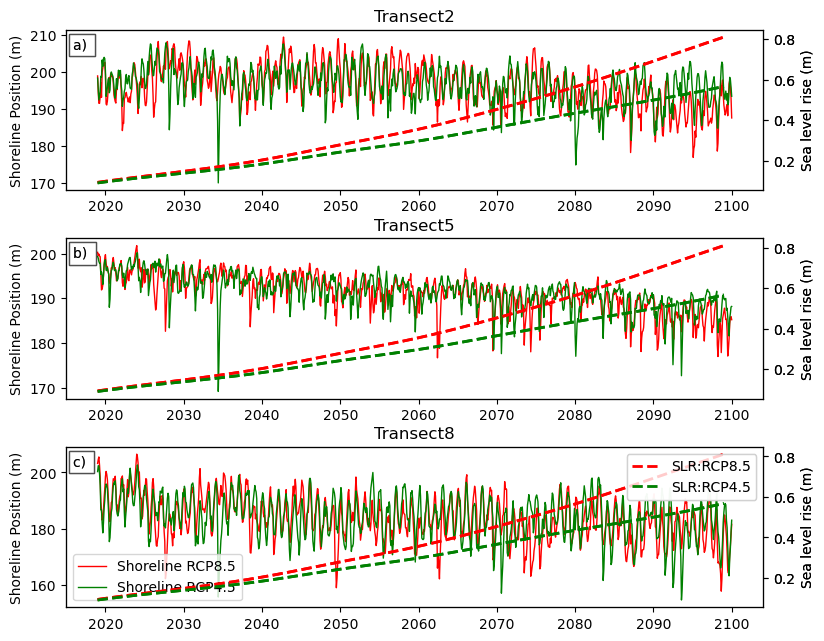

In [33]:
df_SLR = pd.read_csv('datasets/sealevel/sealevel_proj.csv', parse_dates=['Year']).set_index('Year')
ens_colors = {'RCP4.5':'g', 'RCP8.5':'r'}
dfs_sce = {'RCP4.5':dfs_pred_RCP45, 'RCP8.5':dfs_pred_RCP85}
fig, axes = plt.subplots(3, 1, figsize=(9, 2.5*len(TRANSECTS))) 
letters = string.ascii_lowercase # Letters used to label subplots
index = pd.date_range(start='2019-01-01', end='2100-01-01', freq='MS')

for sce in ['RCP8.5', 'RCP4.5']:
    dfs_pred = dfs_sce[sce]
    ensemble_values = []
    for key, df_pred in dfs_pred.items():
        ensemble_values.append(df_pred[TRANSECTS].reindex(index).interpolate().values)  
    ensemble_values = np.stack(ensemble_values)
    #ensemble_mean = np.mean(ensemble_values, axis=0)
    ensemble_mean = percentile_mean(ensemble_values, 10, 90, axis=0)
    ensemble_median = np.median(ensemble_values, axis=0)
    ensemble_max = np.max(ensemble_values, axis=0)
    ensemble_min = np.min(ensemble_values, axis=0)
    ensemble_std = np.std(ensemble_values, axis=0)

    
    for i, tran_id in enumerate(TRANSECTS):
        ax = axes[i]
#         ax.fill_between(index, ensemble_min[:, i], ensemble_max[:, i], color=ens_colors[sce], edgecolor='none', alpha=0.2)
#         ax.fill_between(index, ensemble_mean[:, i]+ensemble_std[:, i], 
#                         ensemble_mean[:, i]-ensemble_std[:, i], color=ens_colors[sce], edgecolor='none', alpha=0.4)
        ax.plot(index, ensemble_mean[:, i], color=ens_colors[sce], label='Shoreline '+sce, linewidth=1)
        
        ax2 = ax.twinx()
        ax2.plot(df_SLR.index, df_SLR['RCP85'], color='r', linewidth=2, linestyle='--', label='SLR:RCP8.5')
        ax2.plot(df_SLR.index, df_SLR['RCP45'], color='g', linewidth=2, linestyle='--', label='SLR:RCP4.5')
        ax2.set_ylabel('Sea level rise (m)')
        
        ax.set_title(tran_id)
        # Add label
        ax.text(0.01,0.95, letters[i] + ') ', 
                    bbox=dict(boxstyle="square", ec='k',fc='w',alpha=0.5), 
                    ha='left',va='top', transform=ax.transAxes, zorder=10)
        ax.set_ylabel('Shoreline Position (m)')

    ax.legend(loc=3)
    ax2.legend(loc=1)
fig.subplots_adjust(hspace=0.3)
plt.savefig('figures/Long/ensemble.jpg', dpi=300, bbox_inches='tight')  

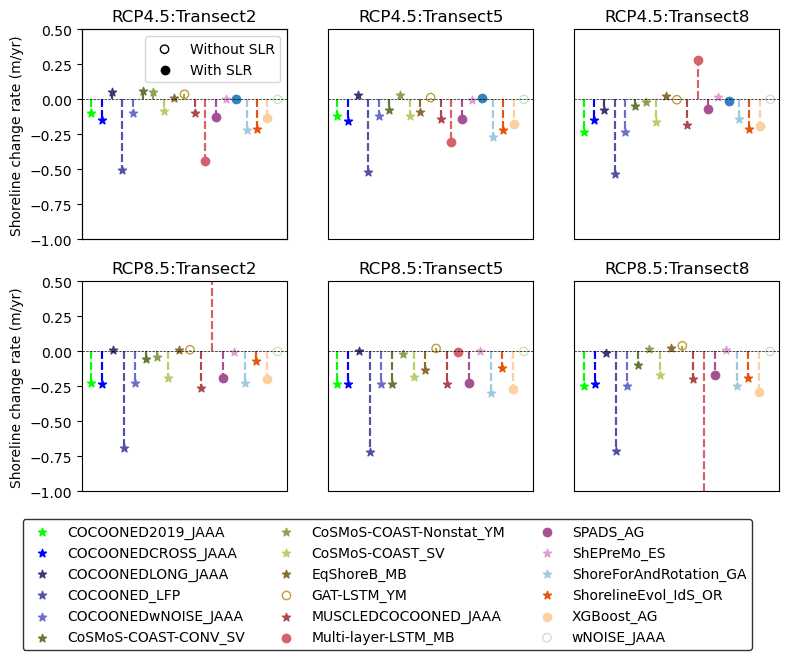

In [34]:
from scipy.stats import linregress
MARKERS = {
'HM': '*',
'DDM':'o',
'LLM': '^',
'ENS': 's',
}
MODEL_COLORS = dict(zip(df_meta['Model Name'], cmap.colors[0:len(df_meta)]))

fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for i, sce in enumerate(['RCP4.5', 'RCP8.5']):    
    for j, tran_id in enumerate(TRANSECTS):
        ax = axes[i, j]
        dfs_pred = dfs_sce[sce]
        for k, (key, df_pred) in enumerate(dfs_pred.items()):
            slr_label = df_meta.loc[df_meta['Model Name']==key, 'Sea level']
            model_type = df_meta.loc[df_meta['Model Name']==key, 'Type'].iloc[0]
            edgecolor = MODEL_COLORS[key]
            if slr_label.isna().iloc[0]:
                facecolor = 'None'
                label = 'Without SLR'
            else:
                facecolor = MODEL_COLORS[key]
                label = 'With SLR'
                
            y = df_pred[tran_id]
            x = df_pred.index.year + (df_pred.index.dayofyear -1)/365
            reg_result = linregress(x, y)
            slope = reg_result.slope
            ax.scatter(k+0.5, slope, marker=MARKERS[model_type], edgecolor=edgecolor, facecolor=facecolor, label=key)
            ax.vlines([k+0.5, k+0.5], ymin=0, ymax=slope, linestyle='--', color=edgecolor)
            
        ax.set_title('{}:{}'.format(sce, tran_id))
        if j == 0:
            ax.set_ylabel('Shoreline change rate (m/yr)')
            if sce == 'RCP4.5':
                ax2 = ax.twinx()
                ax2.scatter([], [], marker='o', 
                            edgecolor='k', facecolor='None', label='Without SLR')
                ax2.scatter([], [], marker='o', 
                            edgecolor='k', facecolor='k', label='With SLR')
                ax2.legend()
                ax2.set_yticks([])
#             ax.bar(0, 0, width=0.5, edgecolor=edgecolor, facecolor='None', label='Without SLR')
#             ax.bar(0, 0, width=0.5, edgecolor=edgecolor, facecolor=edgecolor, label='With SLR')
            if sce == 'RCP8.5':
                 ax.legend(ncol=3, bbox_to_anchor=[3.3,-0.1], edgecolor='k');
        else:
            ax.set_yticks([])
        ax.set_xticks([])
        #ax.set_xticks(np.arange(1, j+2)-0.5)
        ax.axhline(0, linestyle='--', linewidth=0.5, color='k')
        #ax.set_xticklabels(list(dfs_pred.keys()), rotation=90, ha='center')
        if sce == 'RCP4.5':
            ax.set_ylim(-1, 0.5)
        else:
            ax.set_ylim(-1, 0.5)

plt.savefig('figures/Long/SCR.jpg', dpi=300, bbox_inches='tight')  
    